# AI NIST V1

In [3]:
import os

In [11]:
os.chdir('../../Mk_Dataset_NIST/DatasetBK')

import sqlite3
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

class SpectrumDataset(torch.utils.data.Dataset):
    def __init__(self, db_path='final.db', limit=100):
        self.conn = sqlite3.connect(db_path)
        self.cursor = self.conn.cursor()
        self.limit = limit
        self.wavelengths_list = []
        self.intensities_list = []
        self.names_list = []

        self.wavelengths_tensor = torch.tensor([])
        self.intensities_tensor = torch.tensor([])
        self.functional_group_tensor = torch.tensor([])
        self.load_data()

    def load_data(self):
        # Get the total number of molecules
        self.cursor.execute('SELECT COUNT(*) FROM Molecules')
        n_molecules = self.cursor.fetchone()[0]
        print(f"Total number of molecules: {n_molecules}")

        # Fetch molecules
        self.cursor.execute(f'''
            SELECT m.id, m.name, m.smiles
            FROM Molecules m
            WHERE m.id <= {self.limit}
            ORDER BY m.id
        ''')
        molecules = self.cursor.fetchall()

        # Fetch spectrum data for each molecule
        for molecule in molecules:
            self.cursor.execute('''
                SELECT wavelength, intensity
                FROM SpectrumData
                WHERE molecule_id = ?
            ''', (molecule[0],))
            spectrum = self.cursor.fetchall()
            
            wavelengths = [s[0] for s in spectrum]
            intensities = [s[1] for s in spectrum]
            
            # Note: You'll need to define how to create functional_group_tensor
            # This is a placeholder, adjust as needed
            functional_group = torch.tensor([0])  # placeholder
            
            self.add_data(wavelengths, intensities, functional_group, molecule[1])

    def __len__(self):
        return len(self.wavelengths_tensor)

    def __getitem__(self, idx):
        return self.wavelengths_tensor[idx], self.intensities_tensor[idx], self.functional_group_tensor[idx]
    
    def add_data(self, wavelengths_tensor, intensities_tensor, functional_group_tensor, name):
        self.names_list.append(name)
        self.wavelengths_list.append(wavelengths_tensor)
        self.intensities_list.append(intensities_tensor)
        self.functional_group_tensor = torch.cat([self.functional_group_tensor, functional_group_tensor])

    def __del__(self):
        self.conn.close()


dataset = SpectrumDataset()

Total number of molecules: 8966


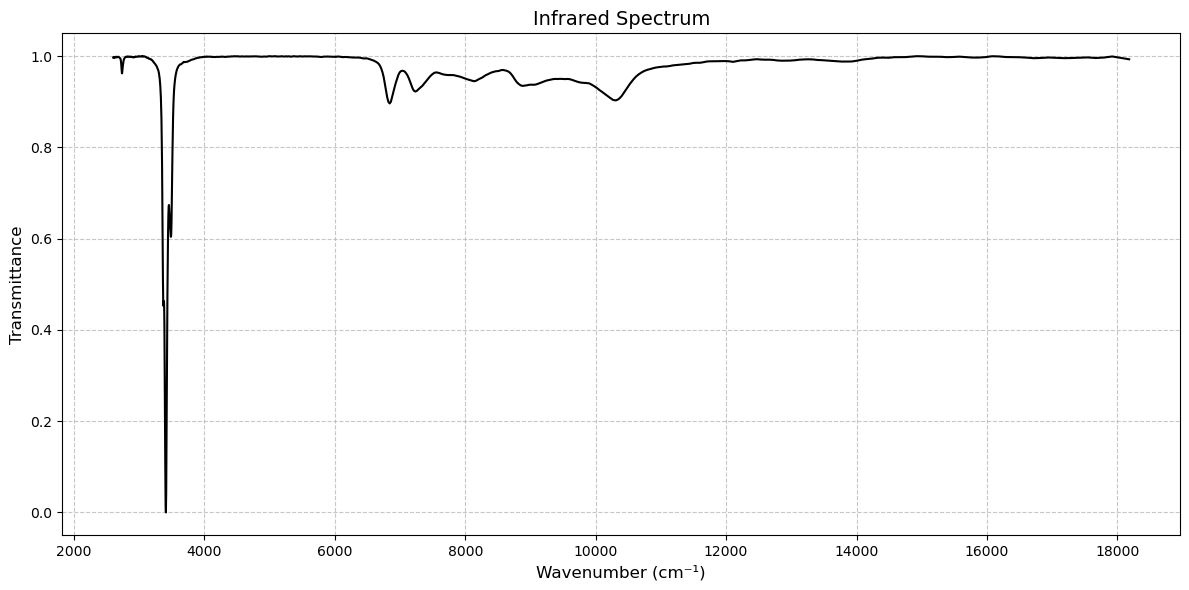

4-Methyl-3-nitrobenzyl alcohol


In [20]:
#print(dataset.wavelengths_list[0])
plot_spectrum(dataset.wavelengths_list[5], dataset.intensities_list[5])
name = dataset.names_list[5]
print(name)


In [6]:
#Clone the dataset
dataset_clone = dataset



In [7]:
#Clone ovrride

dataset = dataset_clone

Original number of spectra: 100
Skipping spectrum Dibenzyl succinate: Insufficient range (580.47 - 141232.61)
Number of spectra after standardization: 99
First wavelength range: 580.00 - 3800.00


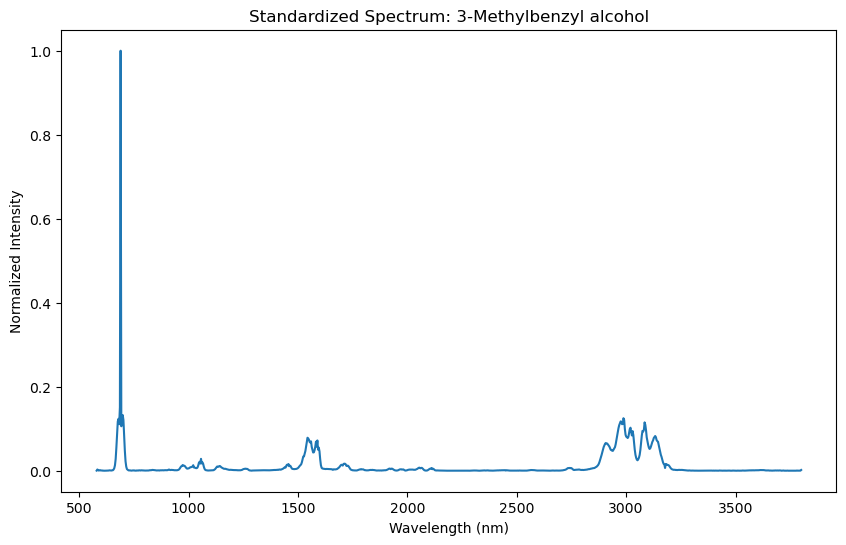

In [8]:
def standardize_data(self):
    if not self.wavelengths_list or not self.intensities_list:
        print("No data to standardize.")
        return

    # Define standard x-axis points (wavelengths)
    min_wavelength = 580
    max_wavelength = 3800
    standard_x = torch.linspace(min_wavelength, max_wavelength, 1000)
    
    standardized_intensities = []
    standardized_wavelengths = []
    valid_names = []
    
    for idx, (wavelengths, intensities, name) in enumerate(zip(self.wavelengths_list, self.intensities_list, self.names_list)):
        # Convert to tensors
        original_x = torch.tensor(wavelengths)
        original_y = torch.tensor(intensities)
        
        # Check if the range is sufficient
        if original_x.min() > min_wavelength or original_x.max() < max_wavelength:
            print(f"Skipping spectrum {name}: Insufficient range ({original_x.min():.2f} - {original_x.max():.2f})")
            continue
        
        # Interpolate to get standardized y values
        interp_func = torch.nn.functional.interpolate
        standardized_y = interp_func(original_y.unsqueeze(0).unsqueeze(0), 
                                     size=1000, 
                                     mode='linear', 
                                     align_corners=False).squeeze()
        
        # Normalize the intensities
        standardized_y = (standardized_y - standardized_y.min()) / (standardized_y.max() - standardized_y.min())
        
        standardized_intensities.append(standardized_y.tolist())
        standardized_wavelengths.append(standard_x.tolist())
        valid_names.append(name)

    # Update the dataset with standardized data
    self.wavelengths_tensor = torch.tensor(standardized_wavelengths)
    self.intensities_tensor = torch.tensor(standardized_intensities)
    self.names_list = valid_names

# Add the method to the class
SpectrumDataset.standardize_data = standardize_data

# Now you can use the method
print(f"Original number of spectra: {len(dataset.wavelengths_list)}")
dataset.standardize_data()
print(f"Number of spectra after standardization: {len(dataset.wavelengths_tensor)}")

if len(dataset.wavelengths_tensor) > 0:
    print(f"First wavelength range: {dataset.wavelengths_tensor[0][0].item():.2f} - {dataset.wavelengths_tensor[0][-1].item():.2f}")
    if len(dataset.intensities_tensor) > 0:
        plt.figure(figsize=(10, 6))
        plt.plot(dataset.wavelengths_tensor[0], dataset.intensities_tensor[0])
        plt.title(f"Standardized Spectrum: {dataset.names_list[0]}")
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Normalized Intensity")
        plt.show()
    else:
        print("No intensity data available.")
else:
    print("No wavelength data available.")

3-Methylbenzyl alcohol


/tmp/ipykernel_14132/2952575669.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  wavelengths = np.array(wavelengths)
/tmp/ipykernel_14132/2952575669.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  intensities = np.array(intensities)  # Ensure it's a numpy array


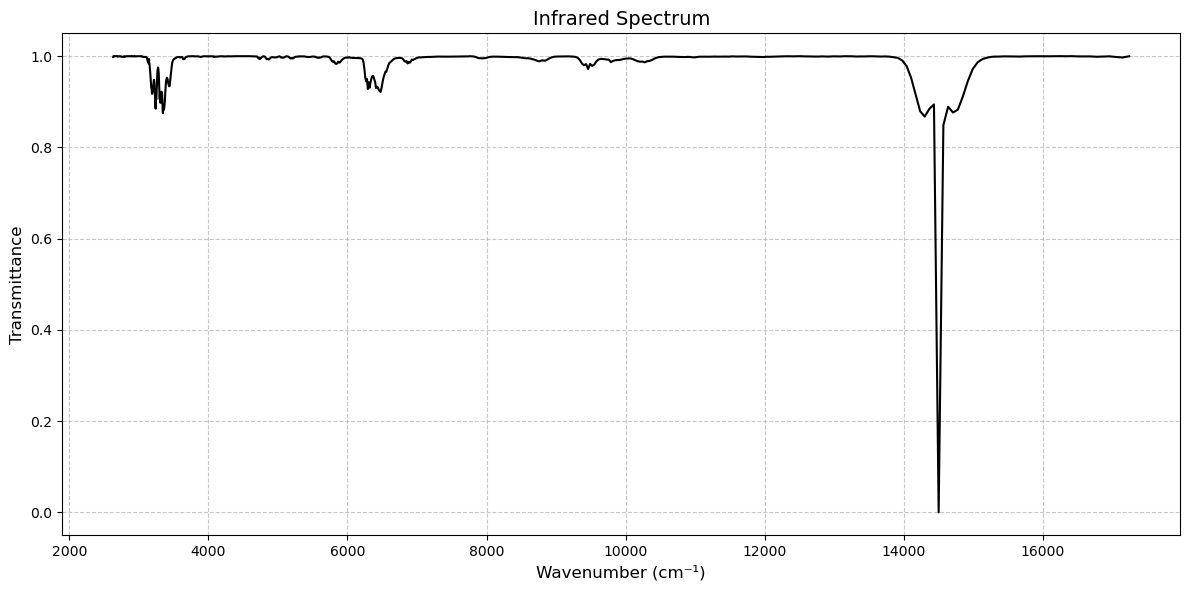

In [9]:
def plot_spectrum(wavelengths, intensities, title="Infrared Spectrum"):
    wavelengths = np.array(wavelengths)
    wavenumbers = 10000000 / wavelengths  # Convert wavelengths (nm) to wavenumbers (cm^-1)
    intensities = np.array(intensities)  # Ensure it's a numpy array
    
    # Transform intensities to range from 0 to 1
    intensities_min = np.min(intensities)
    intensities_max = np.max(intensities)
    intensities = (intensities - intensities_min) / (intensities_max - intensities_min)
    
    # Mirror intensities across the y-axis for transmittance
    transmittance = 1 - intensities
    
    # Plotting the spectrum
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(wavenumbers, transmittance, color='black', linewidth=1.5)
    ax.set_xlabel('Wavenumber (cm⁻¹)', fontsize=12)
    ax.set_ylabel('Transmittance', fontsize=12)
    ax.set_title(title, fontsize=14)
    #ax.invert_xaxis()
    ax.set_ylim(-0.05, 1.05)  # Add a 5% margin on top and bottom
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    plt.tight_layout()
    plt.show()



def plot_spectrum_norescaling(wavelengths, intensities, title="Infrared Spectrum"):
    wavelengths = np.array(wavelengths)
    wavenumbers = 10000000 / wavelengths  # Convert wavelengths (nm) to wavenumbers (cm^-1)
    intensities = np.array(intensities)  # Ensure it's a numpy array
    
    # Plotting the spectrum
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(wavenumbers, intensities, color='black', linewidth=1.5)
    ax.set_xlabel('Wavenumber (cm⁻¹)', fontsize=12)
    ax.set_ylabel('Transmittance', fontsize=12)  # Changed from 'Intensity' to 'Transmittance'
    ax.set_title(title, fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    # Invert x-axis to match the image
    ax.invert_xaxis()
    
    # Set y-axis limits to match the image (0 to 1.2)
    ax.set_ylim(0, 1.2)
    
    plt.tight_layout()
    plt.show()






print(dataset.names_list[0])

plot_spectrum(dataset.wavelengths_tensor[4], dataset.intensities_tensor[0])